In [1]:
# Install the nvcc4jupyter plugin
!pip install nvcc4jupyter

# Load the extension into the notebook
%load_ext nvcc4jupyter


Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmprnw47xhj".


In [2]:
%%cuda
#include <stdio.h>
#include <cuda_runtime.h>

int main() {
    int nDevices;
    cudaGetDeviceCount(&nDevices);
    for (int i = 0; i < nDevices; i++) {
        cudaDeviceProp prop;
        cudaGetDeviceProperties(&prop, i);
        printf("Device Number: %d\n", i);
        printf("  Device name: %s\n", prop.name);
        printf("  Memory Clock Rate (KHz): %d\n", prop.memoryClockRate);
        printf("  Memory Bus Width (bits): %d\n", prop.memoryBusWidth);
        printf("  Peak Memory Bandwidth (GB/s): %f\n\n",
               2.0*prop.memoryClockRate*(prop.memoryBusWidth/8)/1.0e6);
    }
    return 0;
}

Device Number: 0
  Device name: Tesla T4
  Memory Clock Rate (KHz): 5001000
  Memory Bus Width (bits): 256
  Peak Memory Bandwidth (GB/s): 320.064000




In [10]:
%%cuda
#include <iostream>
#include <cuda_runtime.h>
#include <vector>

inline cudaError_t checkCudaErr(cudaError_t result, char const *const func, const int line) {
    if (result != cudaSuccess) {
        std::cerr << "CUDA error = " << static_cast<int>(result) << " at " <<
        func << ":" << line << " '" << cudaGetErrorString(result) << "'" << std::endl;
        exit(1);
    }
    return result;
}
#define CUDA_CHECK(val) checkCudaErr((val), __func__, __LINE__)

__global__ void matmul_rec_glob(float* A, float* B, float* C, int n, int k, int m) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < n && col < m) {
        float sum = 0.0f;
        for (int i = 0; i < k; ++i) {
            sum += A[row * k + i] * B[i * m + col];
        }
        C[row * m + col] = sum;
    }
}

__global__ void matmul_rec_shar(float* A, float* B, float* C, int n, int k, int m) {
    int bx = blockIdx.x, by = blockIdx.y;
    int tx = threadIdx.x, ty = threadIdx.y;
    int row = by * blockDim.y + ty;
    int col = bx * blockDim.x + tx;
    float sum = 0.0f;

    __shared__ float sA[32][32]; // Tile size of 32x32
    __shared__ float sB[32][32];

    for (int t = 0; t < (k + 31) / 32; ++t) {
        if (row < n && (t * 32 + tx) < k)
            sA[ty][tx] = A[row * k + t * 32 + tx];
        else
            sA[ty][tx] = 0.0;

        if (col < m && (t * 32 + ty) < k)
            sB[ty][tx] = B[(t * 32 + ty) * m + col];
        else
            sB[ty][tx] = 0.0;

        __syncthreads();

        for (int i = 0; i < 32; ++i) {
            sum += sA[ty][i] * sB[i][tx];
        }
        __syncthreads();
    }

    if (row < n && col < m)
        C[row * m + col] = sum;
}

void initializeMatrix(float* matrix, int rows, int cols) {
    for (int i = 0; i < rows * cols; i++) {
        matrix[i] = static_cast<float>(rand()) / static_cast<float>(RAND_MAX);
    }
}

int main() {
    std::vector<int> sizes = {4, 16, 64, 256, 1024, 4096};
    for (int n : sizes) {
        int k = n, m = n;
        size_t sizeA = n * k * sizeof(float);
        size_t sizeB = k * m * sizeof(float);
        size_t sizeC = n * m * sizeof(float);

        float *h_A, *h_B, *h_C;
        float *d_A, *d_B, *d_C;

        // Allocate host memory
        h_A = (float*)malloc(sizeA);
        h_B = (float*)malloc(sizeB);
        h_C = (float*)malloc(sizeC);

        // Initialize matrices
        initializeMatrix(h_A, n, k);
        initializeMatrix(h_B, k, m);

        // Allocate device memory
        CUDA_CHECK(cudaMalloc((void**)&d_A, sizeA));
        CUDA_CHECK(cudaMalloc((void**)&d_B, sizeB));
        CUDA_CHECK(cudaMalloc((void**)&d_C, sizeC));

        // Copy data from host to device
        CUDA_CHECK(cudaMemcpy(d_A, h_A, sizeA, cudaMemcpyHostToDevice));
        CUDA_CHECK(cudaMemcpy(d_B, h_B, sizeB, cudaMemcpyHostToDevice));

        // Setup execution parameters
        dim3 threadsPerBlock(32, 32);
        dim3 blocksPerGrid((m + threadsPerBlock.x - 1) / threadsPerBlock.x, (n + threadsPerBlock.y - 1) / threadsPerBlock.y);

        // Timing variables
        float milliseconds = 0;
        cudaEvent_t start, stop;
        CUDA_CHECK(cudaEventCreate(&start));
        CUDA_CHECK(cudaEventCreate(&stop));

        // Launch kernels multiple times and average the results
        int numTrials = 10;
        float totalTimeGlob = 0, totalTimeShar = 0;
        for (int i = 0; i < numTrials; ++i) {
            // Global memory kernel
            CUDA_CHECK(cudaEventRecord(start));
            matmul_rec_glob<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, n, k, m);
            CUDA_CHECK(cudaEventRecord(stop));
            CUDA_CHECK(cudaEventSynchronize(stop));
            CUDA_CHECK(cudaEventElapsedTime(&milliseconds, start, stop));
            totalTimeGlob += milliseconds;

            // Shared memory kernel
            CUDA_CHECK(cudaEventRecord(start));
            matmul_rec_shar<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, n, k, m);
            CUDA_CHECK(cudaEventRecord(stop));
            CUDA_CHECK(cudaEventSynchronize(stop));
            CUDA_CHECK(cudaEventElapsedTime(&milliseconds, start, stop));
            totalTimeShar += milliseconds;
        }

        std::cout << "Average time for matrix size " << n << "x" << n << " using global memory: "
                  << totalTimeGlob / numTrials << " ms" << std::endl;
        std::cout << "Average time for matrix size " << n << "x" << n << " using shared memory: "
                  << totalTimeShar / numTrials << " ms" << std::endl;

        // Free device memory
        CUDA_CHECK(cudaFree(d_A));
        CUDA_CHECK(cudaFree(d_B));
        CUDA_CHECK(cudaFree(d_C));

        // Free host memory
        free(h_A);
        free(h_B);
        free(h_C);

        CUDA_CHECK(cudaEventDestroy(start));
        CUDA_CHECK(cudaEventDestroy(stop));
    }

    return 0;
}

Average time for matrix size 4x4 using global memory: 0.0279488 ms
Average time for matrix size 4x4 using shared memory: 0.012512 ms
Average time for matrix size 16x16 using global memory: 0.0083488 ms
Average time for matrix size 16x16 using shared memory: 0.0113728 ms
Average time for matrix size 64x64 using global memory: 0.0221568 ms
Average time for matrix size 64x64 using shared memory: 0.0170016 ms
Average time for matrix size 256x256 using global memory: 0.133091 ms
Average time for matrix size 256x256 using shared memory: 0.109306 ms
Average time for matrix size 1024x1024 using global memory: 6.64068 ms
Average time for matrix size 1024x1024 using shared memory: 5.32209 ms
Average time for matrix size 4096x4096 using global memory: 233.494 ms
Average time for matrix size 4096x4096 using shared memory: 157.987 ms



In [1]:
%pip install seaborn pandas

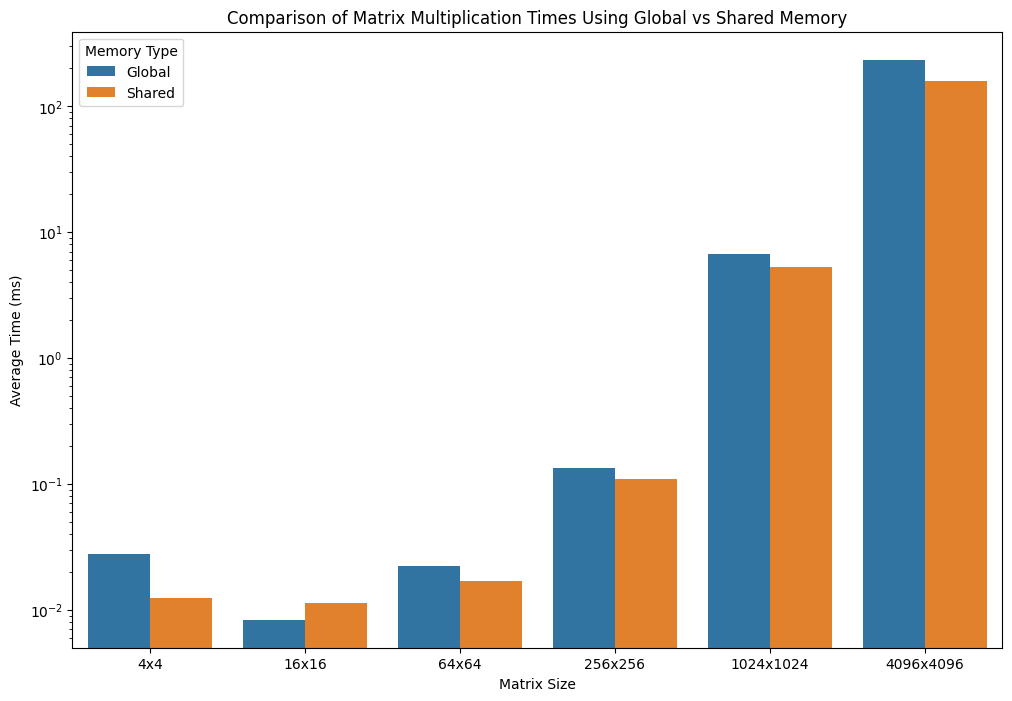

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Matrix Size": ["4x4", "4x4", "16x16", "16x16", "64x64", "64x64", "256x256", "256x256", "1024x1024", "1024x1024", "4096x4096", "4096x4096"],
    "Average Time (ms)": [0.0279488, 0.012512, 0.0083488, 0.0113728, 0.0221568, 0.0170016, 0.133091, 0.109306, 6.64068, 5.32209, 233.494, 157.987],
    "Memory Type": ["Global", "Shared", "Global", "Shared", "Global", "Shared", "Global", "Shared", "Global", "Shared", "Global", "Shared"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Create a factor plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Matrix Size", y="Average Time (ms)", hue="Memory Type", data=df)
plt.title('Comparison of Matrix Multiplication Times Using Global vs Shared Memory')
plt.xlabel('Matrix Size')
plt.ylabel('Average Time (ms)')
plt.yscale('log')  # Use logarithmic scale for better visualization of large range values
plt.show()
